## Object Detection (pretrained model)

Model and guidline were taken from this [article](https://www.analyticsvidhya.com/blog/2020/04/build-your-own-object-detection-model-using-tensorflow-api/)

Model detect what is on photo and return photo with detected labels and labels itself.

In [1]:
from imageai.Detection import ObjectDetection

Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
C:\Users\anpej\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

import pathlib

In [3]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Loading model from tensorflow.org

In [4]:
def load_model(model_name):
    
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model

In [7]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
model_name = 'faster_rcnn_resnet101_coco_11_06_2017'
detection_model = load_model(model_name)

print(detection_model.inputs)
detection_model.output_dtypes

# Runing the model to detect what on photo
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
    output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   # Handle models with masks:
    if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    return output_dict

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [91]:
# Creating photo with boxes and dictionary of labels and probabilities
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
  # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks_reframed', None),
          use_normalized_coordinates=True,
          line_thickness=8)

    labels_scores = {}
    for i in range(len(output_dict['detection_classes'])):
        labels_scores[category_index[output_dict['detection_classes'][i]]['name']] = output_dict['detection_scores'][i]
    print(labels_scores)
    for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
    display(Image.fromarray(image_np))

{'cat': 0.9985656, 'couch': 0.4222907, 'bed': 0.37542772}


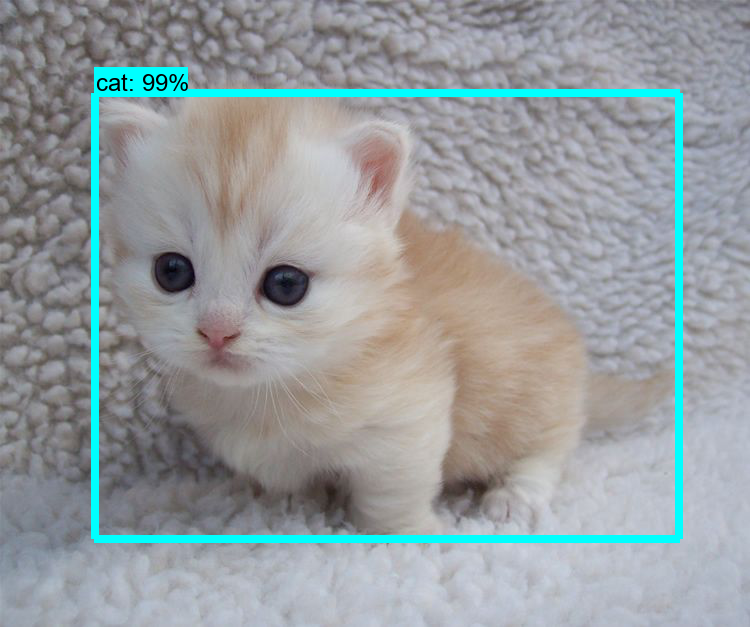

{'apple': 0.9920508, 'dining table': 0.45876303}


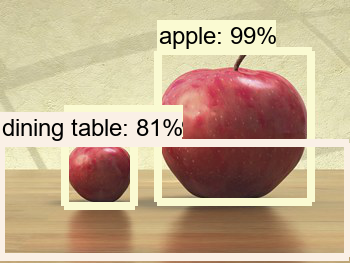

{'scissors': 0.41598603, 'spoon': 0.4689019, 'knife': 0.3258127}


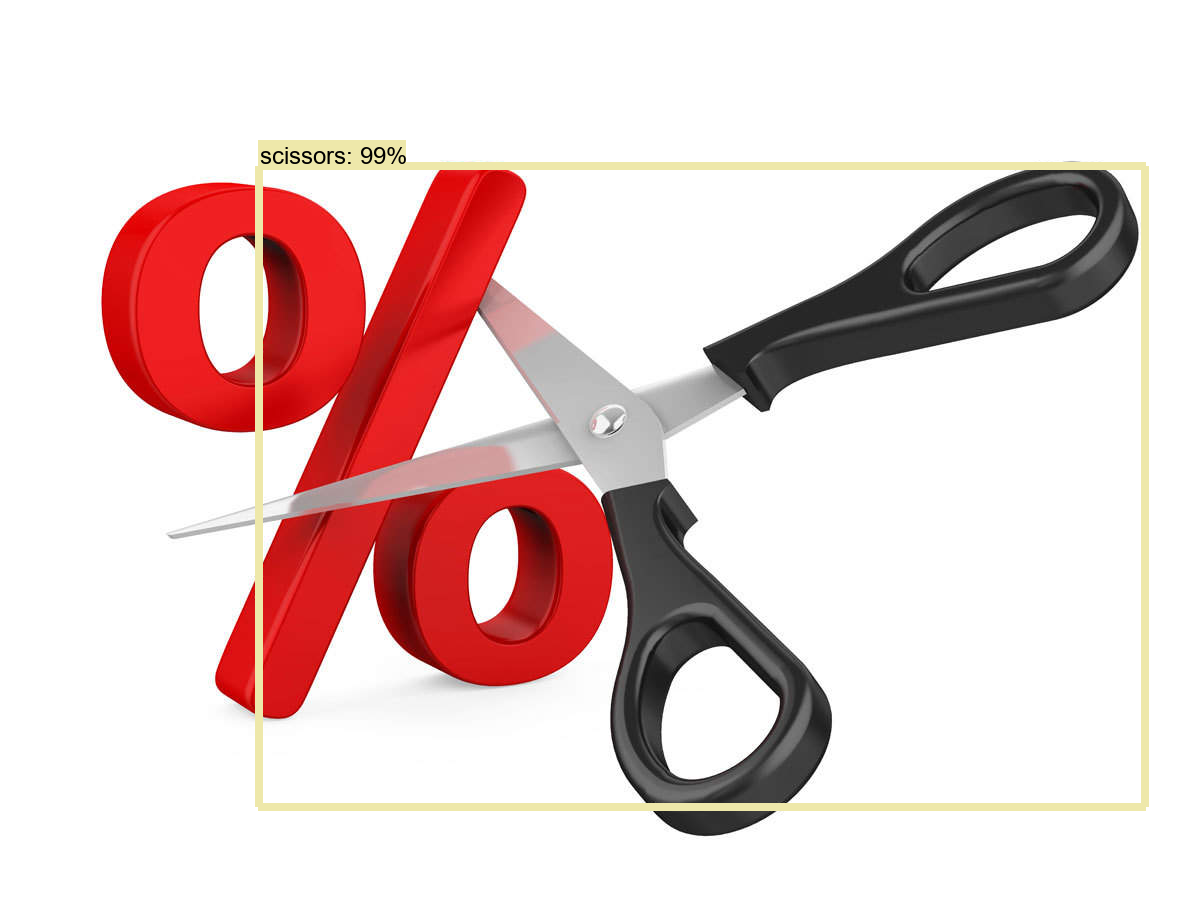

{'suitcase': 0.85514235, 'handbag': 0.40295842}


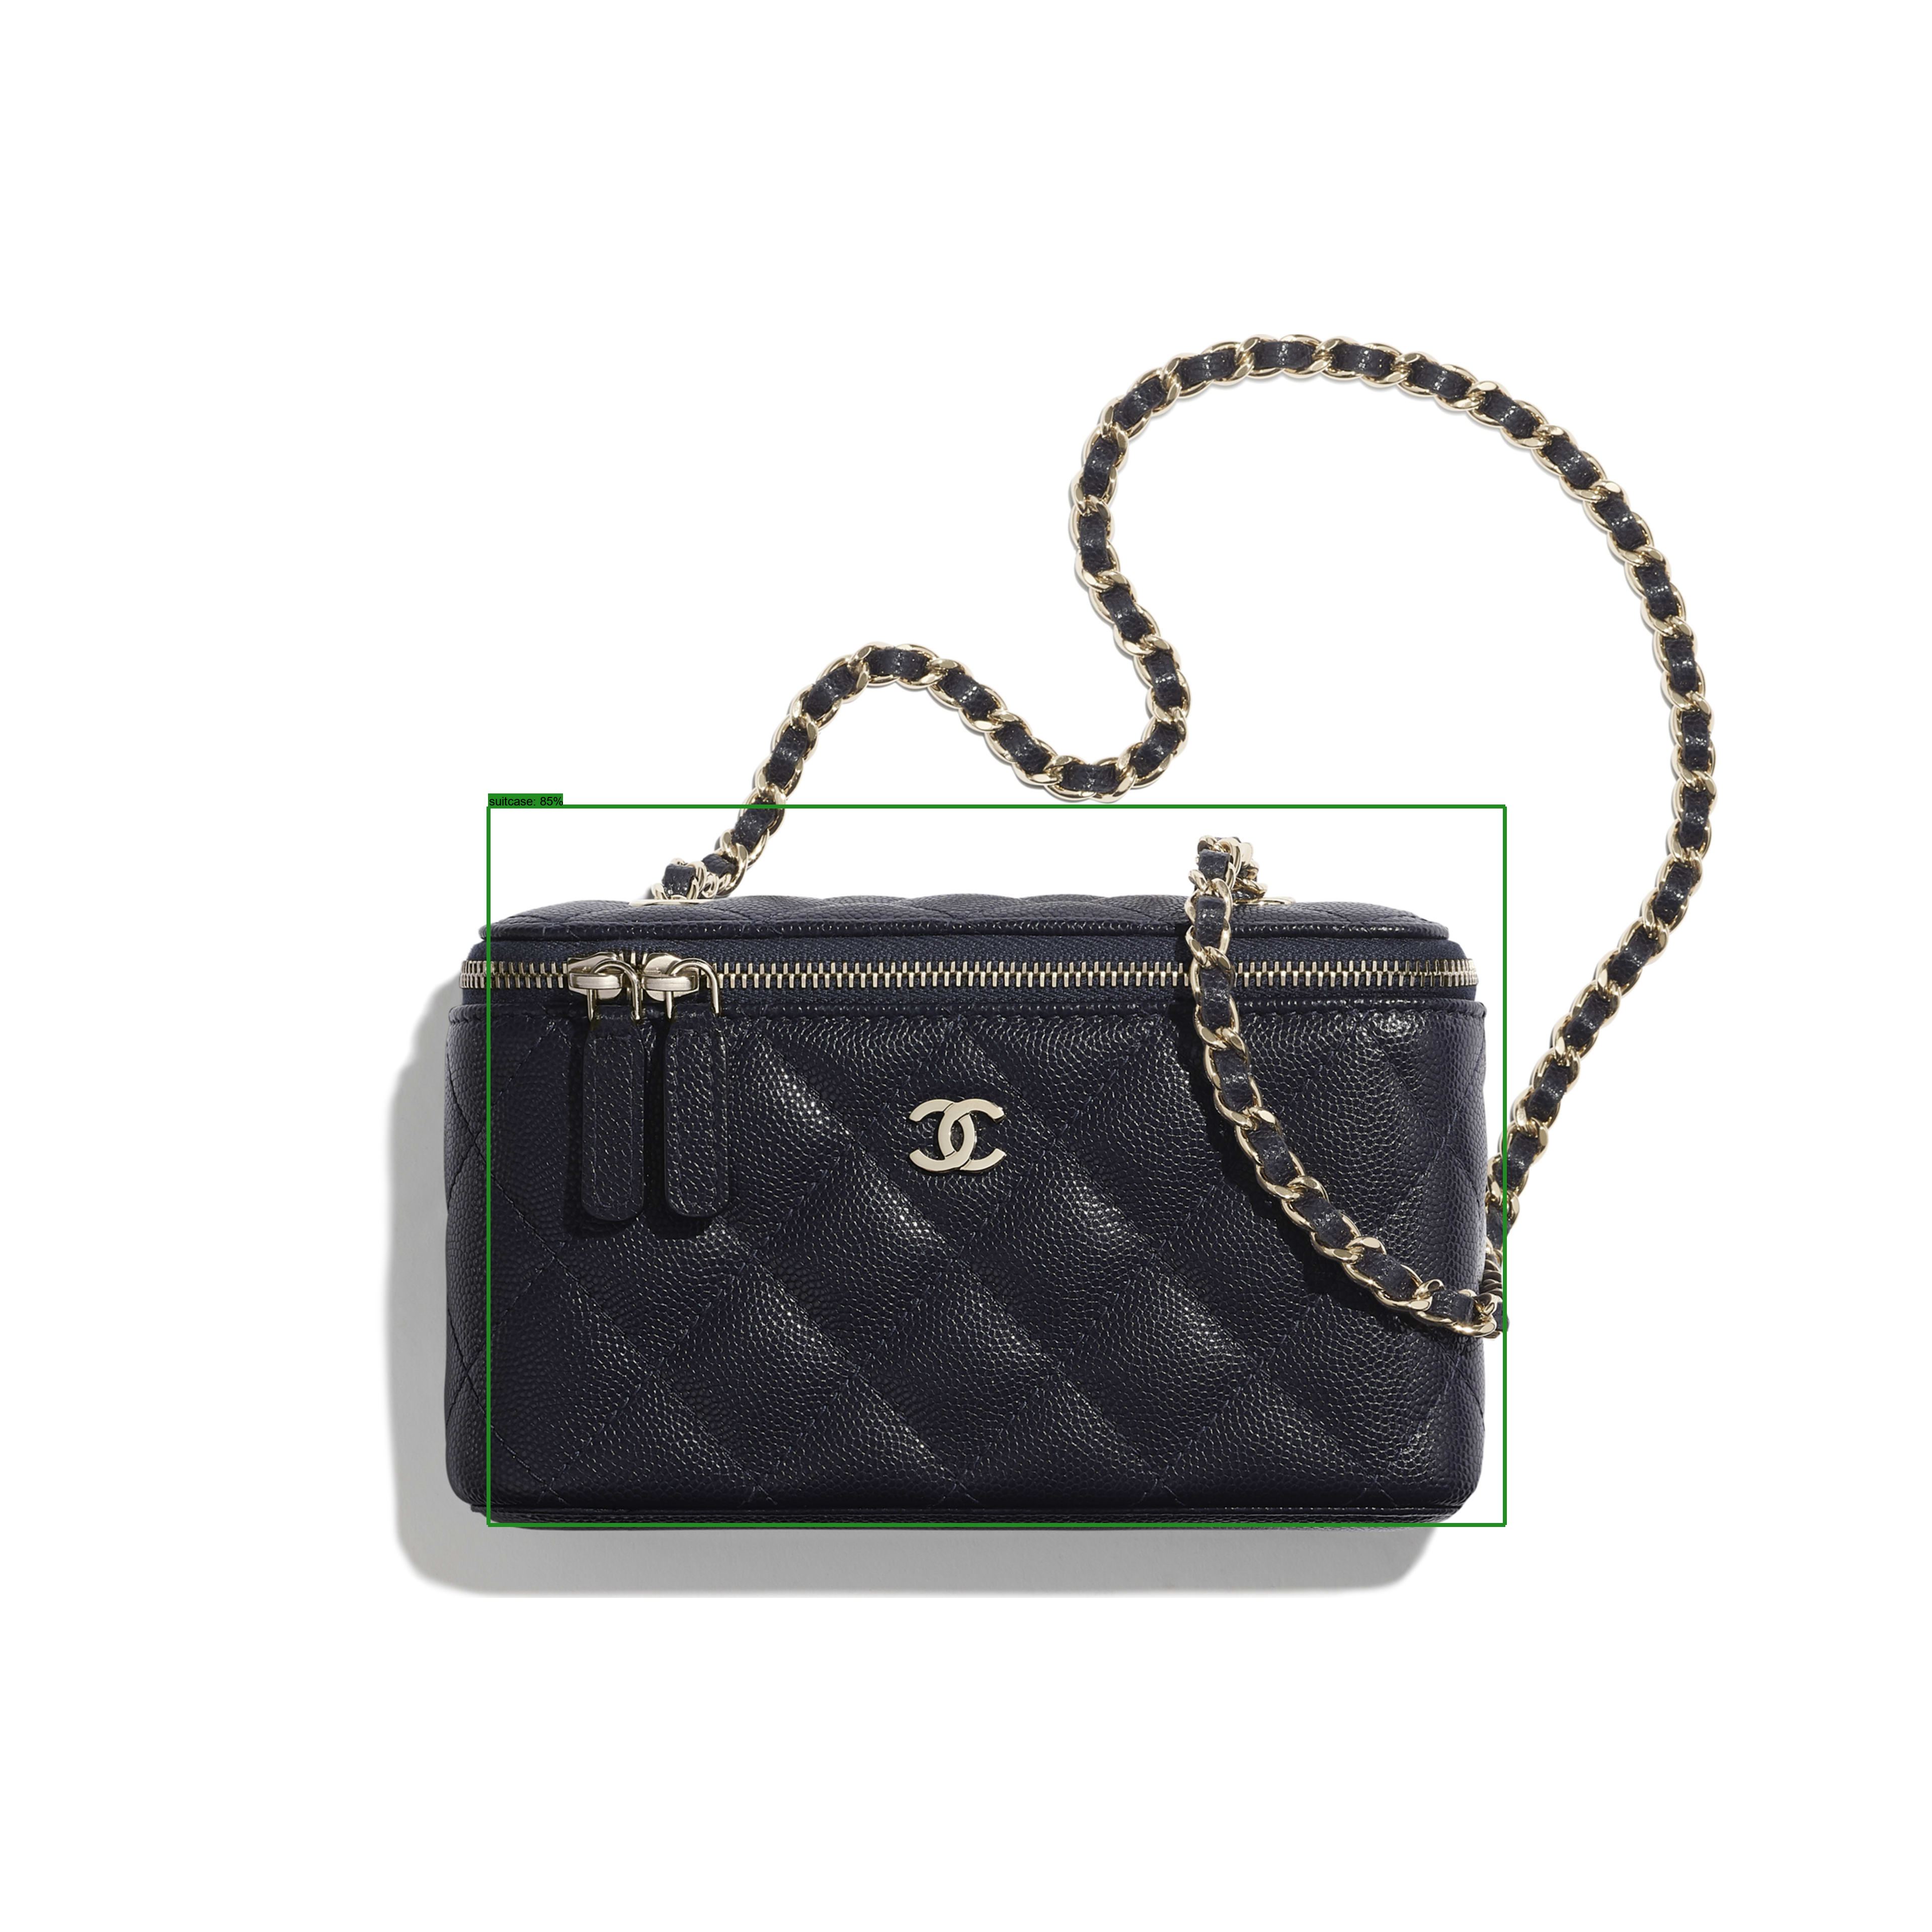

{'cup': 0.7959697, 'vase': 0.40703532, 'knife': 0.326781}


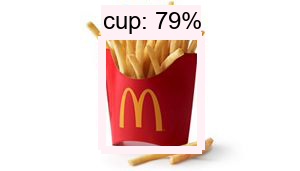

In [92]:
# Runing model
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
for image_path in TEST_IMAGE_PATHS:
    show_inference(detection_model, image_path)
